In [83]:
# Let us import nltk tool
import nltk

# Importing necessory packages
import pandas as pd
import numpy as np

# Importing packages for plotting
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline

In [84]:
# Getting the data
dataset = pd.read_csv('/spam.csv', encoding = "ISO-8859-1")

# Removing unwanted column
dataset = dataset[['v1', 'v2']]

# Name the columns
dataset.columns = ['label', 'message']

dataset.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## **Train and Test Split**

In [85]:
from sklearn.model_selection import train_test_split

# Splitting the data
x_train, x_test, y_train, y_test = train_test_split(dataset['message'], dataset['label'], test_size=0.33)

## **EDA**

In [86]:
# Describing the dataset
x_train.describe()

count                       3733
unique                      3514
top       Sorry, I'll call later
freq                          22
Name: message, dtype: object

Some of the messages are repeating it seems.

In [87]:
# Let us see which messages were repeating
x_train.value_counts().head()

Sorry, I'll call later                                                                                                                      22
I cant pick the phone right now. Pls send a message                                                                                          9
Ok...                                                                                                                                        6
Your opinion about me? 1. Over 2. Jada 3. Kusruthi 4. Lovable 5. Silent 6. Spl character 7. Not matured 8. Stylish 9. Simple Pls reply..     4
Ok.                                                                                                                                          4
Name: message, dtype: int64

These are the most common repeating messages

Now let us see how many of the messages were spam and how many were not.

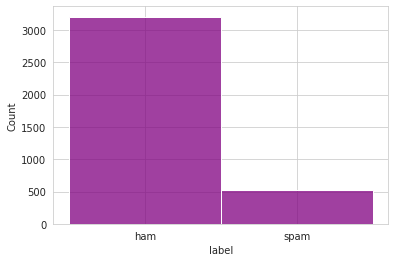

In [88]:
sns.histplot(x=y_train, color='purple')
plt.show()

In [89]:
y_train.describe().transpose()

count     3733
unique       2
top        ham
freq      3206
Name: label, dtype: object

Now let us find enough features for classification. First, we will go with the length of the messages.

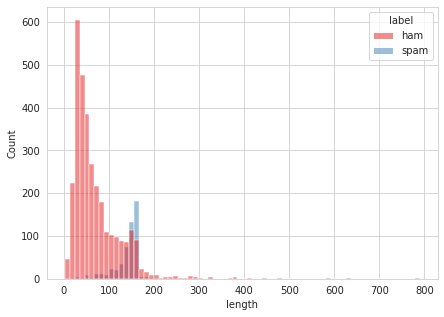

In [90]:
x_train_df = pd.DataFrame(x_train, columns=['message'])

x_train_df['length'] = x_train_df['message'].apply(len)
plt.subplots(figsize=(7, 5))

# Let us plot this now
sns.histplot(data=x_train_df, x='length', hue=y_train, palette='Set1')
plt.show()

It is  clear that length of the message has an influence on the label.

## **Data Engineering**

Before doing anything, we have to convert the strings  to vector  form. For this we will first remove the stop words and punctuations.

In [91]:
import string
from nltk.tokenize import word_tokenize
nltk.download('punkt')

# Downloading stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords

# Defining the  stop words
stopwords = stopwords.words('english')

# Defining punctuations
punctuations = string.punctuation

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [92]:
# Defining the function to remove the punctuations and stopwords
def alter_text(sent):
  return [word for word in word_tokenize(sent) if (word not in punctuations) and (word not in stopwords)]

In [93]:
# Removing the stopwords and punctuation for the training dataset
x_train = x_train_df['message'].apply(alter_text)

### **Lemittizing**

Now we will lemmitize these words for better training the model.

In [94]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet

# Function to find the type of word
lemattizer_dict = {'V': wordnet.VERB,
                   'J': wordnet.ADJ,
                   'R': wordnet.ADV}
def find_type(string):
  return lemattizer_dict.get(string, wordnet.NOUN)

# Function to lemitize
def lemattize(message):
  lemattizer = nltk.WordNetLemmatizer()
  return [lemattizer.lemmatize(token, find_type(typ[0])) for (token, typ) in nltk.pos_tag(word_tokenize(' '.join(message))) if token.isalpha()]

# Function to convert strings to useful format
words = []
def convert_string(messages):
  temp = []
  for message in messages:
    result = lemattize(message)
    words.extend(result)
    temp.append(str(result))
  return temp

x_train = convert_string(x_train)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Here words would be the bag of words

### **Vectorization**

We will convert the sentences into numerical forms here.


#### **Count Vectorizer**

In [95]:
# Importing the vectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Creating the vectorizer
vectorizer = CountVectorizer()

# Fitting and transforming
x_train_vect = vectorizer.fit_transform(x_train)

#### **TFIDF Vectorizer**

Tfidf is used to find the inverse frequency of occurance of a word in a sentence compared to the frequency of occurancy of the same word in the whole document.

In [96]:
# Importing the vectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Creating the vectorizer
transformer = TfidfTransformer()

# Fitting and transforming
x_train_tfid = transformer.fit_transform(x_train_vect)

## **Modeling**

We will use naive bayes model for classification as each features are independent on each other. And naive bayes follows the theoy of conditional probability.

In [97]:
# Importing the package
from sklearn.naive_bayes import MultinomialNB

# Creating the model
nb = MultinomialNB()

# Fitting the model with the dataset for training
nb.fit(x_train_tfid, y_train)

MultinomialNB()

Now we have to engineer the x_test for prediction.

In [98]:
# Removing the stopwords and punctuation for the training dataset
x_test = x_test.apply(alter_text)

# Function to convert strings to useful format
x_test = convert_string(x_test)

# Using count vectorizer
x_test_vect = vectorizer.transform(x_test)

# Using tfid transformer
x_test_tfid = transformer.transform(x_test_vect)

Predicting for test values

In [99]:
# Prediction
pred = nb.predict(x_test_tfid)

In [104]:
# Accuracy Score
from sklearn.metrics import accuracy_score

accuracy_score(pred, y_test)

0.965742251223491

**WE GOT IT 96% ACCURATE** 